In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm


In [2]:
Year = "2019"
Month = "11"
Day = "28"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [28]:
def harmonics_processor(folder,max_file=5,shake_freq=13,no_harmonics=10,fsamp=5000,res=50000,res_factor=10,save_file=True):
    #path="/harmonics/"
    #try:
    #    os.mkdir(path)
    #except OSError:
    #    print ("Creation of the directory %s failed" % path)
    #else:
    #    print ("Successfully created the directory %s " % path)
    files = load_dir_sorted(folder, file_prefix = 'Shaking', max_file=max_file)
    harmonic_list =[]
    xmean_list,ymean_list,zmean_list = ([] for i in range(3))
    cant_xpos_list,cant_ypos_list,cant_zpos_list=([] for i in range(3))                
    for i in tqdm(np.arange(0,len(files),1)):
        #print(files[i].fname)
        data = files[i].xyz2
        print(files[0].time)
        print(files[1].time)
        xmean_list.append(np.mean(files[i].x2))
        ymean_list.append(np.mean(files[i].y2))
        zmean_list.append(np.mean(files[i].z2))
        cant_xpos_list.append(np.mean(files[i].cant_pos[0]))
        cant_ypos_list.append(np.mean(files[i].cant_pos[1]))
        cant_zpos_list.append(np.mean(files[i].cant_pos[2]))
        data_det=signal.detrend(data)
        x=data_det[0]
        y=data_det[1]
        z=data_det[2]
        res = res
        fsamp = fsamp # stays hard coded for now
        xpsd, freqs = matplotlib.mlab.psd(x, Fs = fsamp, NFFT = res)
        ypsd, freqs = matplotlib.mlab.psd(y, Fs = fsamp, NFFT = res)
        zpsd, freqs = matplotlib.mlab.psd(z, Fs = fsamp, NFFT = res)
        freqs,harmonics = get_harmonics(xpsd,shake_freq=shake_freq,no_harmonics=no_harmonics)
        harmonic_list.append(np.sqrt(harmonics))
    df = pd.DataFrame(harmonic_list)
    df["x_mean"]=xmean_list
    df["y_mean"]=ymean_list
    df["z_mean"]=zmean_list
    df["attractor_position_x"]=cant_xpos_list
    df["attractor_position_y"]=cant_ypos_list
    df["attractor_position_z"]=cant_zpos_list
    if(save_file==True):
        df.to_csv(folder+"harmonics/harmonics_basic_1000.csv",index=False)
    return df

In [30]:
folder_shaking = "/Shaking/Shaking24/"
folder = folder_basic + folder_shaking
df_shaking_test = harmonics_processor(folder,max_file=10,shake_freq=13,no_harmonics=15,res_factor=10)

 50%|█████     | 5/10 [00:00<00:00, 47.93it/s]

1000  files in folder
10  files loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded
Time not loaded


100%|██████████| 10/10 [00:00<00:00, 47.42it/s]


In [7]:
folder_shaking = "/Shaking/Shaking2/"
folder = folder_basic + folder_shaking
df_shaking_shield = harmonics_processor(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10)

  1%|          | 7/999 [00:00<00:15, 62.35it/s]

999  files in folder
999  files loaded


100%|██████████| 999/999 [00:18<00:00, 53.83it/s]


In [8]:
folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
df_shaking_no_shield = harmonics_processor(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10)

  0%|          | 5/1000 [00:00<00:23, 42.52it/s]

1000  files in folder
1000  files loaded


100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


In [10]:
# load for string conversion and to test its running

folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
df_shaking_no_shield = pd.read_csv(folder+"harmonics/harmonics_basic_1000.csv")

In [18]:
Year = "2019"
Month = "11"
Day = "14"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [20]:
# load for string conversion and to test its running

folder_shaking = "/Shaking/Shaking25/"
folder = folder_basic + folder_shaking
df_shaking25 = pd.read_csv(folder+"harmonics/harmonics_basic_1000.csv")

In [21]:
meanws,stdws, sumws, medianws = get_mean_std_sum_of_harmonics(df_shaking_shield,no_harmonics=15)
meanwos,stdwos, sumwos, medianwos = get_mean_std_sum_of_harmonics(df_shaking_no_shield,no_harmonics=15)
mean24,std24, sum24, median24 = get_mean_std_sum_of_harmonics(df_shaking24,no_harmonics=15)
mean25,std25, sum25, median25 = get_mean_std_sum_of_harmonics(df_shaking25,no_harmonics=15)



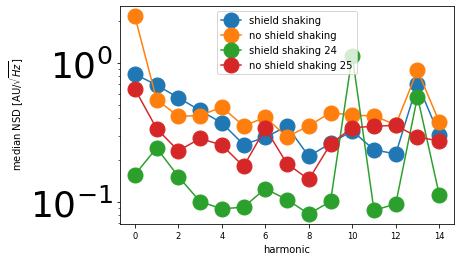

In [24]:
plt.plot(np.arange(0,15,1),sumws,marker="o",linestyle="-",markersize="15", label = "shield shaking")
plt.plot(np.arange(0,15,1),sumwos,marker="o",linestyle="-",markersize="15", label = "no shield shaking")
plt.plot(np.arange(0,15,1),sum24,marker="o",linestyle="-",markersize="15", label = "shield shaking 24")
plt.plot(np.arange(0,15,1),sum25,marker="o",linestyle="-",markersize="15", label = "no shield shaking 25")



#plt.plot(np.arange(0,15,1),np.divide(mean26,std26),marker="o",linestyle="", label = "servo on")
#plt.plot(np.arange(0,15,1),np.divide(mean27,std27),marker="o",linestyle="", label = "no servo")
#plt.plot(np.arange(0,15,1),median28,marker="o",linestyle="",markersize="15", label = "no shaking")
plt.legend()
plt.yscale("log")
plt.ylabel(r" median NSD [AU/$\sqrt{Hz}$]")
plt.xlabel("harmonic")
plt.show()

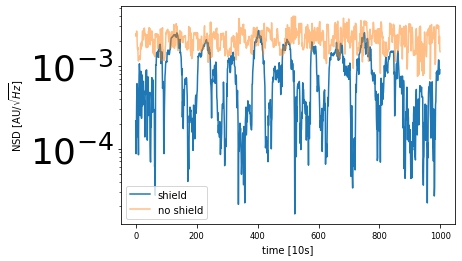

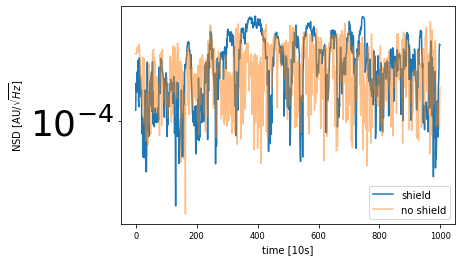

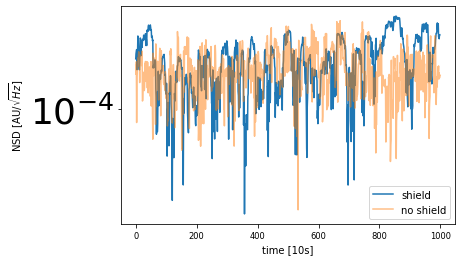

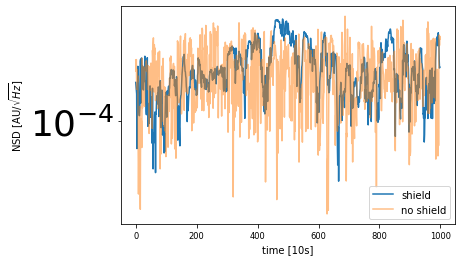

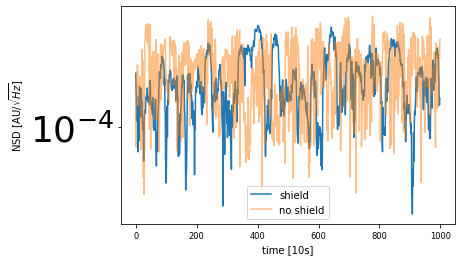

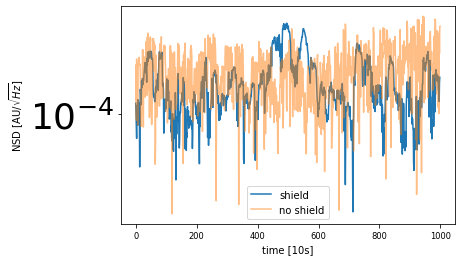

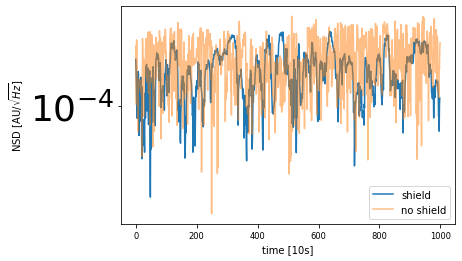

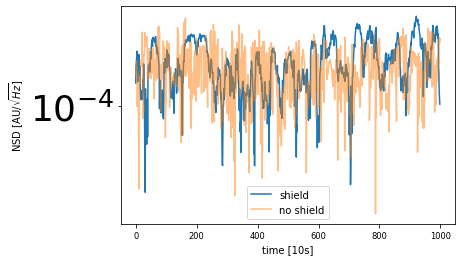

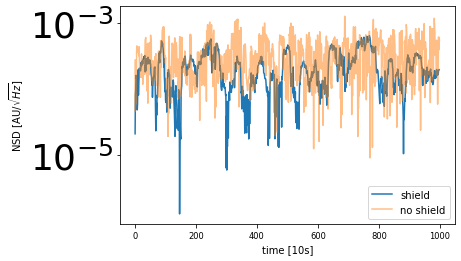

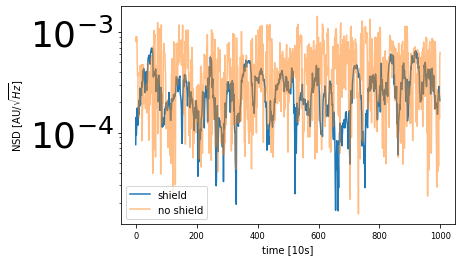

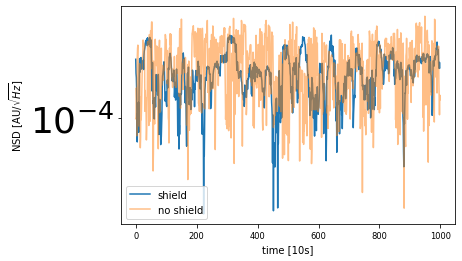

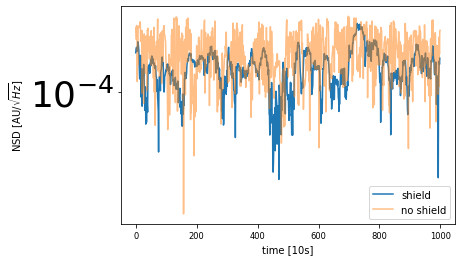

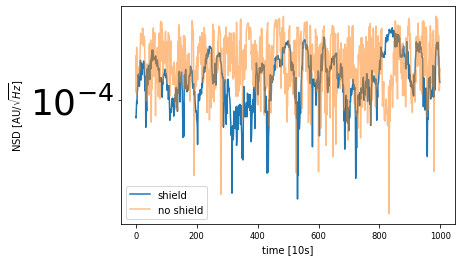

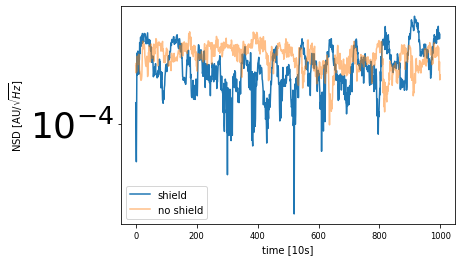

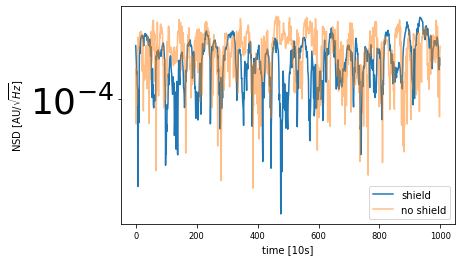

In [25]:
for i in np.arange(0,15,1):
    harmonic = i
    plt.plot(df_shaking_shield["%d" %harmonic], label = "shield")
    plt.plot(df_shaking_no_shield["%d" %harmonic], label = "no shield",alpha=0.5)
    plt.legend()
    plt.ylabel(r"NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("time [10s]")
    plt.yscale("log")
   #plt.savefig("%d_harmonic.png" %harmonic, dpi=300, bbox_inches ="tight")
    plt.show()

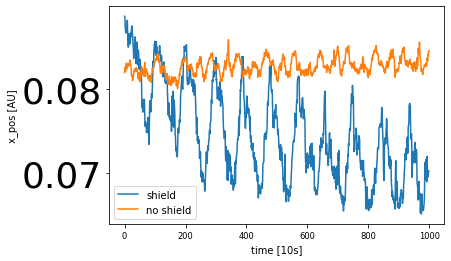

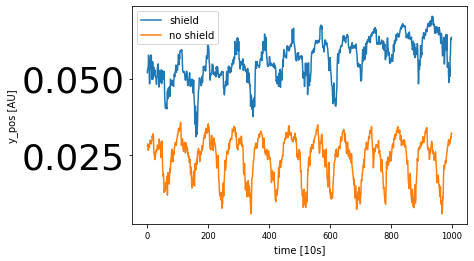

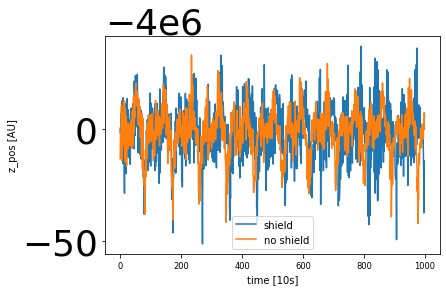

In [26]:
axis = ["x","y","z"]
for element in axis:
    plt.plot(df_shaking_shield["%s_mean" %element], label = "shield")
    plt.plot(df_shaking_no_shield["%s_mean" %element], label = "no shield")
    plt.legend()
    plt.ylabel(r"%s_pos [AU]" %element)
    plt.xlabel("time [10s]")
    #plt.yscale("log")
   #plt.savefig("%s_mean.png" %element, dpi=300, bbox_inches ="tight")
    plt.show()

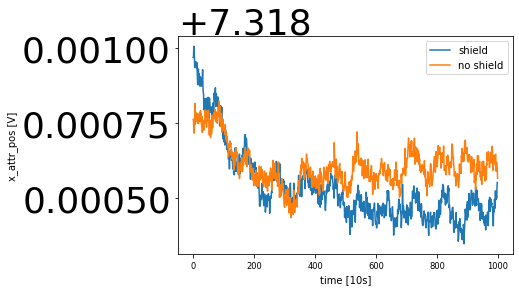

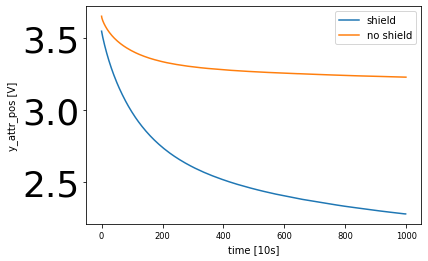

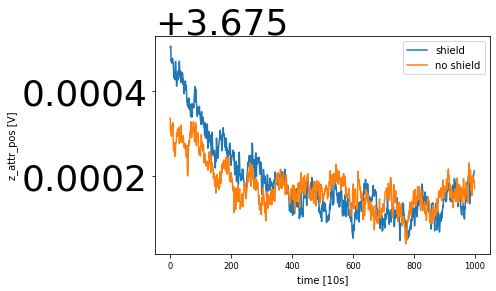

In [27]:
axis = ["x","y","z"]
for element in axis:
    plt.plot(df_shaking_shield["attractor_position_%s" %element], label = "shield")
    plt.plot(df_shaking_no_shield["attractor_position_%s" %element], label = "no shield")
    plt.legend()
    plt.ylabel(r"%s_attr_pos [V]" %element)
    plt.xlabel("time [10s]")
    #plt.yscale("log")
    #plt.savefig("attractor_position_%s.png" %element, dpi=300, bbox_inches ="tight")
    plt.show()

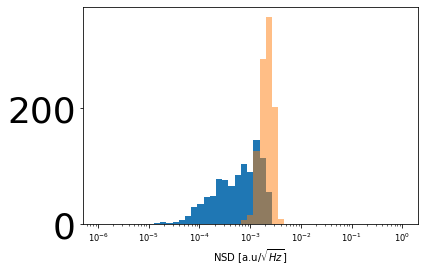

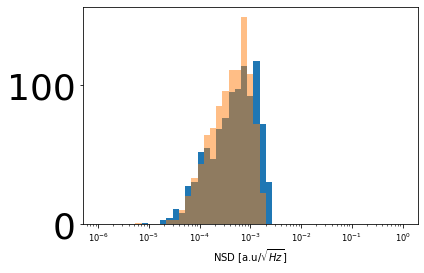

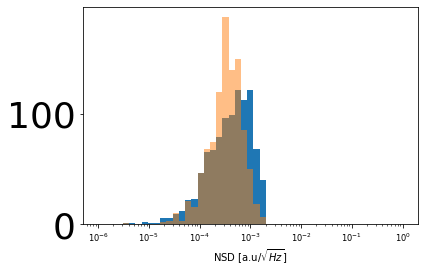

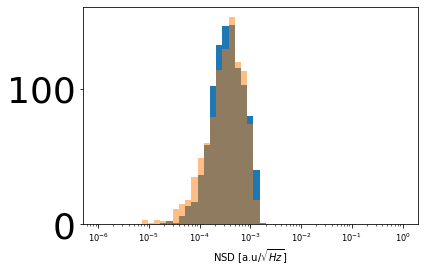

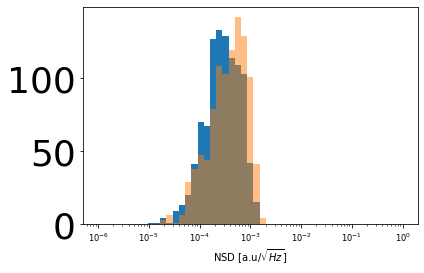

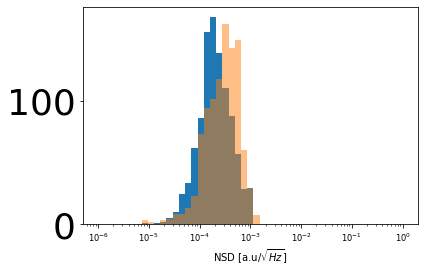

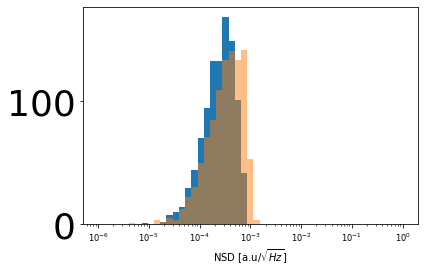

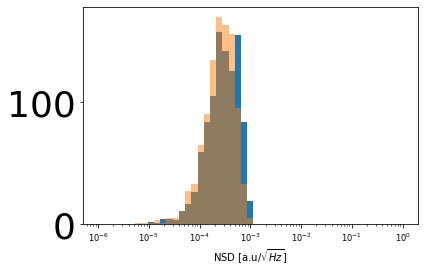

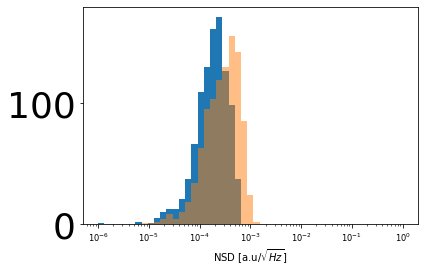

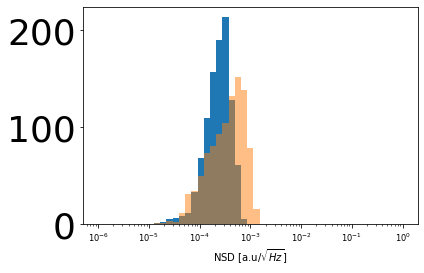

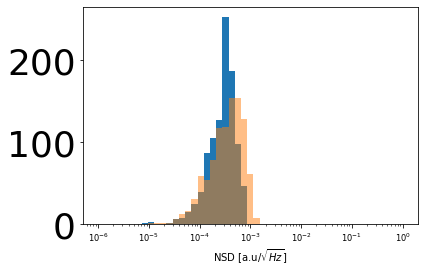

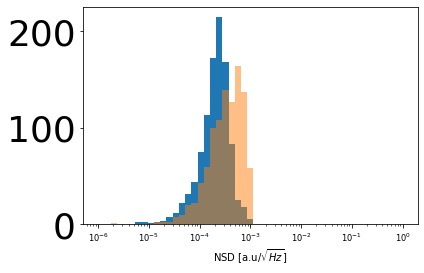

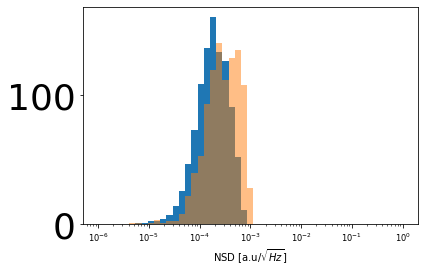

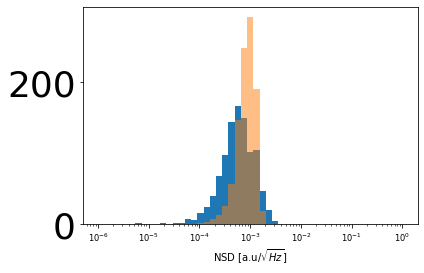

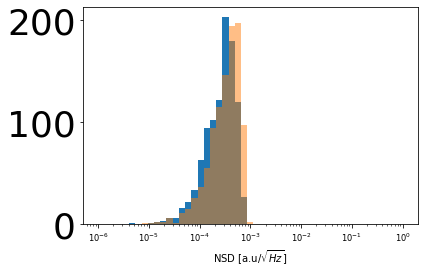

In [31]:
for i in np.arange(0,15,1):
    harmonic =i
#plt.hist(df_shaking24["%d" %harmonic], bins=bins,range=(0,1e-6))
#plt.hist(df_shaking25["%d" %harmonic], bins=bins, alpha=0.5,range=(0,1e-6))
#plt.hist(df_shaking26["%d" %harmonic], bins=bins, alpha=0.3,range=(0,1e-6))
    plt.hist(df_shaking_shield["%d" %harmonic], bins=np.logspace(np.log10(1e-6),np.log10(1), 50))
    plt.hist(df_shaking_no_shield["%d" %harmonic], bins=np.logspace(np.log10(1e-6),np.log10(1), 50),alpha=0.5)
    plt.xlabel(r"NSD [a.u/$\sqrt{Hz}$]")
    plt.xscale("log")
    #plt.savefig("Results/histo_amp_%d" %harmonic, bbox_inches = "tight")
    plt.show()
    